In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

# Variables de configuración
image_size = 128
apply_rotation = True
apply_translation = True
apply_scaling = True
apply_flipping = True
apply_histogram_equalization = False
apply_brightness_contrast_adjustment = True
apply_noise_injection = False

# Verificar si CUDA está disponible y usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA available:", torch.cuda.is_available())
print("Using device:", device)

if torch.cuda.is_available():
    print("Nombre de la tarjeta gráfica:", torch.cuda.get_device_name(0))
    print("Memoria total de la tarjeta gráfica: {:.2f} GB".format(torch.cuda.get_device_properties(0).total_memory / 1e9))
    print("Memoria disponible antes del entrenamiento: {:.2f} GB".format(torch.cuda.memory_reserved(0) / 1e9))
    print("Memoria asignada antes del entrenamiento: {:.2f} GB".format(torch.cuda.memory_allocated(0) / 1e9))

# Definir transformaciones básicas
basic_transform = [
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
]

# Aumento de datos
augmentation_transform = []
if apply_rotation:
    augmentation_transform.append(transforms.RandomRotation(10))  # Rotación aleatoria de hasta 10 grados
if apply_translation:
    augmentation_transform.append(transforms.RandomAffine(0, translate=(0.1, 0.1)))  # Traslación de hasta el 10%
if apply_scaling:
    augmentation_transform.append(transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)))  # Escalado aleatorio
if apply_flipping:
    augmentation_transform.append(transforms.RandomHorizontalFlip())  # Volteo horizontal aleatorio
if apply_brightness_contrast_adjustment:
    augmentation_transform.append(transforms.ColorJitter(brightness=0.2, contrast=0.2))  # Ajuste de brillo y contraste

# Función para inyectar ruido
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

# Agregar inyección de ruido si está activada
if apply_noise_injection:
    augmentation_transform.append(AddGaussianNoise(0., 0.1))

# Composición final de transformaciones
transform = transforms.Compose(basic_transform + augmentation_transform)

# Cargar conjuntos de datos
train_dataset = datasets.ImageFolder(root='datasets/ASL_Alphabet_Dataset/asl_alphabet_train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

test_dataset = datasets.ImageFolder(root='datasets/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Visualizar la primera imagen de cada clase antes de entrenar el modelo
def show_first_image_of_each_class(dataset, num_images=5):
    class_to_idx = dataset.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    first_images = []
    labels = []
    
    for class_name in class_to_idx.keys():
        class_index = class_to_idx[class_name]
        for img_path, target in dataset.samples:
            if target == class_index:
                first_images.append(img_path)
                labels.append(class_name)
                break
    
    fig, axes = plt.subplots(1, len(first_images), figsize=(15, 15))
    for i, img_path in enumerate(first_images):
        img = Image.open(img_path).convert('L')
        img = transform(img)
        img = img.numpy()
        axes[i].imshow(img[0] * 0.5 + 0.5, cmap='gray')  # Des-normalizar y mostrar en escala de grises
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis('off')
    plt.show()

print("Primera imagen de cada clase preprocesada para entrenamiento:")
show_first_image_of_each_class(train_dataset)
# Definir el modelo para imágenes de tamaño variable
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * (image_size // 4) * (image_size // 4), 128)  # Ajustar tamaño para imágenes
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 29)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * (image_size // 4) * (image_size // 4))
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN().to(device)
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Función de entrenamiento
def train_model(model, train_loader, criterion, optimizer, num_epochs=15):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                pbar.set_postfix({"loss": loss.item()})
                pbar.update(1)
        
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        if torch.cuda.is_available():
            print(f"Memoria asignada durante el entrenamiento: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
            print(f"Memoria reservada durante el entrenamiento: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")
            torch.cuda.empty_cache()

# Entrenar el modelo
train_model(model, train_loader, criterion, optimizer, num_epochs=15)

# Guardar el modelo entrenado
torch.save(model.state_dict(), f'ASL_language_model_{image_size}x{image_size}_grayscale.pth')

CUDA available: True
Using device: cuda
Nombre de la tarjeta gráfica: NVIDIA GeForce RTX 3070
Memoria total de la tarjeta gráfica: 8.59 GB
Memoria disponible antes del entrenamiento: 13.75 GB
Memoria asignada antes del entrenamiento: 2.45 GB


Función de evaluación

In [21]:
# Función de evaluación
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")

# Evaluar el modelo
evaluate_model(model, test_loader)

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[63, 1, 128, 128] to have 3 channels, but got 1 channels instead

MAIN:

In [22]:
# Ver resumen de la memoria
if torch.cuda.is_available():
    print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 631705 KiB |   7726 MiB |  58214 GiB |  58213 GiB |
|       from large pool | 630976 KiB |   7725 MiB |  58189 GiB |  58188 GiB |
|       from small pool |    729 KiB |      1 MiB |     24 GiB |     24 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 631705 KiB |   7726 MiB |  58214 GiB |  58213 GiB |
|       from large pool | 630976 KiB |   7725 MiB |  58189 GiB |

TEST ACCURACY = 17.857142857142858%


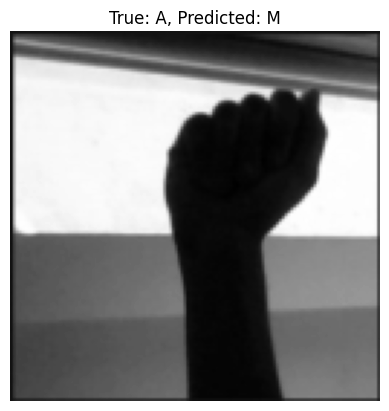

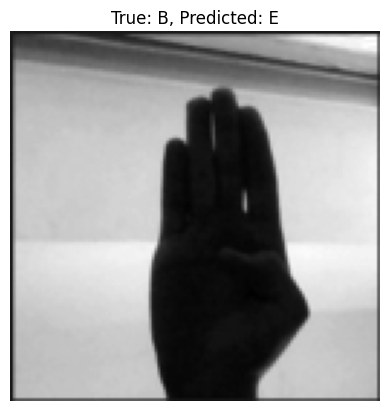

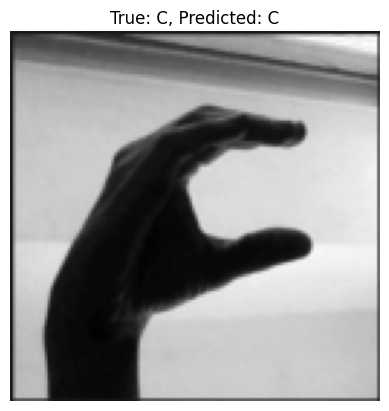

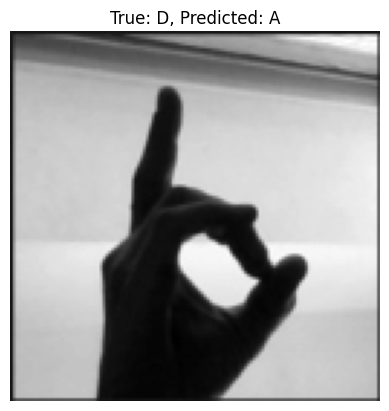

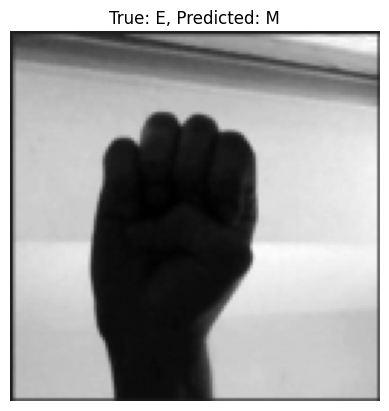

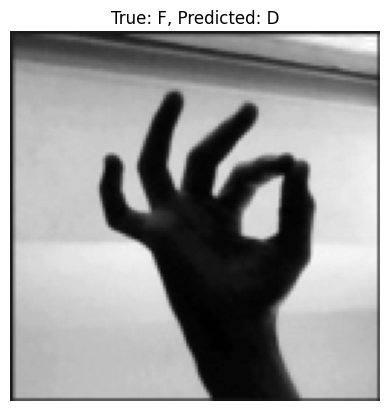

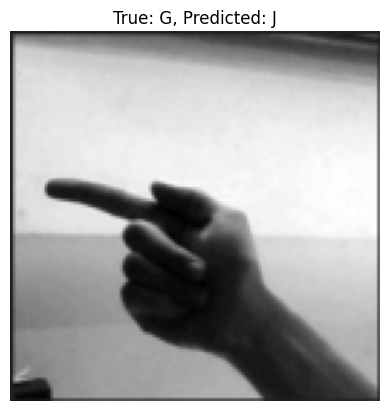

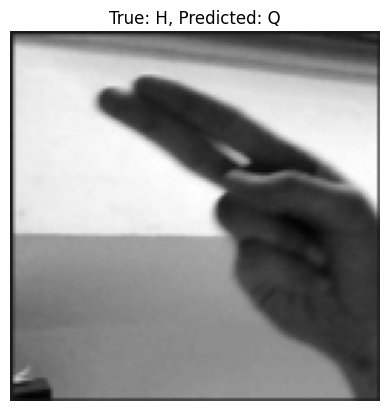

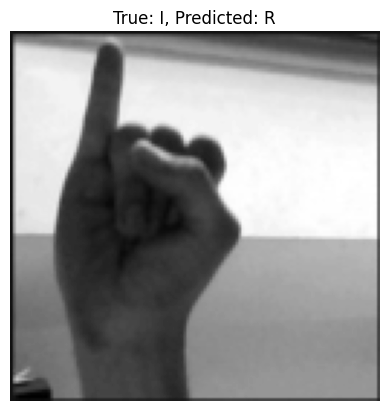

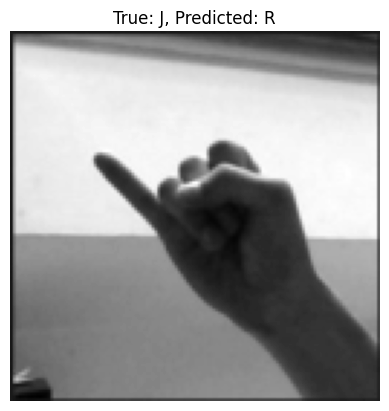

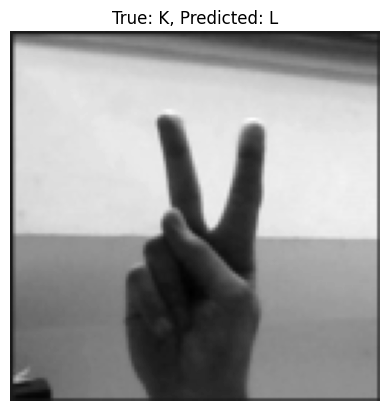

In [54]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Configuración
image_size = 128  # Asegúrate de que coincida con el tamaño utilizado durante el entrenamiento
model_path = f'ASL_language_model_{image_size}x{image_size}_grayscale.pth'
test_dir = 'datasets/ASL_Alphabet_Dataset/asl_alphabet_test'

# Definir transformaciones para las imágenes de prueba
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Mapeo de nombres de archivos a etiquetas
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']

# Definir el modelo
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * (image_size // 4) * (image_size // 4), 128)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 29)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * (image_size // 4) * (image_size // 4))
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Cargar el modelo guardado
model = CNN()
model.load_state_dict(torch.load(model_path))
model.eval()

# Procesar y cargar imágenes de prueba manualmente
test_images = []
test_labels = []

for class_name in class_names:
    image_path = os.path.join(test_dir, f"{class_name}_test.jpg")
    if os.path.exists(image_path):
        img = Image.open(image_path).convert('L')
        img = transform(img)
        test_images.append(img)
        test_labels.append(class_names.index(class_name))

# Convertir listas a tensores de PyTorch
test_images = torch.stack(test_images)
test_labels = torch.tensor(test_labels)

# Evaluación del modelo en el conjunto de prueba
with torch.no_grad():
    outputs = model(test_images)
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(outputs, test_labels)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == test_labels).sum().item() / len(test_labels)

print('TEST ACCURACY = {}%'.format(accuracy * 100))

# Mostrar las imágenes con sus predicciones
for i in range(len(test_images)):
    plt.imshow(test_images[i][0].numpy() * 0.5 + 0.5, cmap='gray')  # Des-normalizar y mostrar en escala de grises
    plt.title(f"True: {class_names[test_labels[i]]}, Predicted: {class_names[predicted[i]]}")
    plt.axis('off')
    plt.show()
    if i == 10:  # Mostrar solo los primeros 10 resultados
        break


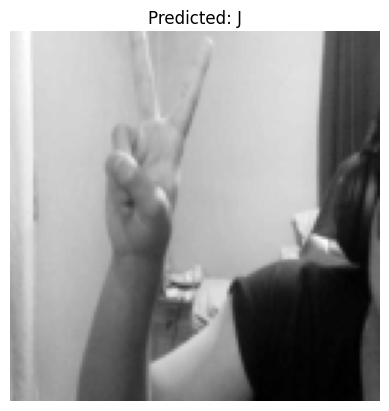

In [47]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# Configuración
image_size = 128  # Asegúrate de que coincida con el tamaño utilizado durante el entrenamiento
model_path = f'ASL_language_model_{image_size}x{image_size}_grayscale.pth'

# Definir el modelo
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * (image_size // 4) * (image_size // 4), 128)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 29)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * (image_size // 4) * (image_size // 4))
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Cargar el modelo guardado
model = CNN()
model.load_state_dict(torch.load(model_path))
model.eval()

# Definir transformaciones para las imágenes de prueba
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Mapeo de nombres de archivos a etiquetas
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']

def capture_image():
    # Capturar imagen desde la cámara
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: No se puede abrir la cámara.")
        return None
    
    ret, frame = cap.read()
    if not ret:
        print("Error: No se puede leer la imagen de la cámara.")
        cap.release()
        return None

    # Guardar la imagen capturada temporalmente
    image_path = 'captured_image.png'
    cv2.imwrite(image_path, frame)

    # Liberar la cámara
    cap.release()
    cv2.destroyAllWindows()
    return image_path

def preprocess_image(image_path, target_size=(64, 64)):
    # Cargar y procesar la imagen
    img = Image.open(image_path).convert('L')
    img = transform(img)
    img = img.unsqueeze(0)  # Añadir dimensión para el lote
    return img

def predict_image_from_camera():
    # Capturar la imagen
    image_path = capture_image()
    if image_path is None:
        return

    # Preprocesar la imagen capturada
    img_tensor = preprocess_image(image_path, target_size=(image_size, image_size))
    
    # Realizar predicción
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted_class = torch.max(outputs, 1)
        predicted_label = class_names[predicted_class.item()]

    # Mostrar la imagen preprocesada con la predicción
    plt.imshow(img_tensor[0][0].numpy() * 0.5 + 0.5, cmap='gray')  # Des-normalizar la imagen
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Llamar a la función para predecir la imagen de la cámara
predict_image_from_camera()


In [1]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import cv2
import numpy as np
import mediapipe as mp
import time

# Configuración
image_size = 128  # Asegúrate de que coincida con el tamaño utilizado durante el entrenamiento
model_path = f'ASL_language_model_{image_size}x{image_size}_grayscale.pth'

# Definir el modelo
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * (image_size // 4) * (image_size // 4), 128)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 29)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * (image_size // 4) * (image_size // 4))
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Cargar el modelo guardado
model = CNN()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# Definir transformaciones para las imágenes de prueba
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Mapeo de nombres de archivos a etiquetas
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']

# Configuración de Mediapipe
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def preprocess_image(frame, target_size=(128, 128)):
    # Convertir el frame a un formato compatible
    img = Image.fromarray(frame).convert('L')
    img = transform(img)
    img = img.unsqueeze(0)  # Añadir dimensión para el lote
    return img

def predict_frame(frame):
    # Preprocesar el frame capturado
    img_tensor = preprocess_image(frame, target_size=(image_size, image_size))
    
    # Realizar predicción
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted_class = torch.max(outputs, 1)
        predicted_label = class_names[predicted_class.item()]
    
    return predicted_label

def main():
    # Capturar video desde la cámara
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: No se puede abrir la cámara.")
        return

    with mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.7) as hands:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Error: No se puede leer la imagen de la cámara.")
                break

            # Convertir el frame a RGB para Mediapipe
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(rgb_frame)

            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    # Extraer las coordenadas de la caja delimitadora de la mano
                    h, w, c = frame.shape
                    x_min = min([landmark.x for landmark in hand_landmarks.landmark]) * w
                    x_max = max([landmark.x for landmark in hand_landmarks.landmark]) * w
                    y_min = min([landmark.y for landmark in hand_landmarks.landmark]) * h
                    y_max = max([landmark.y for landmark in hand_landmarks.landmark]) * h

                    # Asegurarse de que las coordenadas estén dentro de los límites de la imagen
                    x_min = max(0, int(x_min))
                    x_max = min(w, int(x_max))
                    y_min = max(0, int(y_min))
                    y_max = min(h, int(y_max))

                    # Dibujar un rectángulo alrededor de la mano
                    cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

                    # Realizar predicción sobre la región de la mano
                    hand_frame = frame[y_min:y_max, x_min:x_max]
                    if hand_frame.size != 0:
                        predicted_label = predict_frame(hand_frame)
                        # Mostrar la predicción en el frame
                        cv2.putText(frame, f'Predicted: {predicted_label}', (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

            # Mostrar el frame con la predicción
            cv2.imshow('ASL Prediction', frame)

            # Salir del loop si se presiona la tecla 'q'
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    # Liberar la cámara y cerrar todas las ventanas
    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()


c:\Users\207814636\AppData\Local\Programs\Python\Python39\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import detection
from PIL import Image
import numpy as np
import cv2
import time
from tqdm import tqdm

# Configuración
image_size = 128  # Tamaño de imagen para el modelo CNN
cooldown_time = 2  # Tiempo de cooldown en segundos
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definir el modelo CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * (image_size // 4) * (image_size // 4), 128)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 29)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * (image_size // 4) * (image_size // 4))
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Cargar el modelo CNN guardado
cnn_model = CNN()
cnn_model.load_state_dict(torch.load(f'ASL_language_model_{image_size}x{image_size}_grayscale.pth'))
cnn_model.to(device)
cnn_model.eval()

# Definir las transformaciones para las imágenes de prueba
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Mapeo de nombres de archivos a etiquetas
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']

# Usar YOLOv5 de torchvision para la detección de manos
yolo_model = detection.fasterrcnn_resnet50_fpn(pretrained=True)
yolo_model = yolo_model.to(device)
yolo_model.eval()

def preprocess_image(frame, target_size=(128, 128)):
    # Convertir el frame a un formato compatible con el modelo CNN
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, target_size)
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=0)
    img = torch.tensor(img, dtype=torch.float32) / 255.0
    img = img.to(device)
    return img

def predict_gesture(frame):
    img_tensor = preprocess_image(frame, target_size=(image_size, image_size))
    with torch.no_grad():
        outputs = cnn_model(img_tensor)
        _, predicted_class = torch.max(outputs, 1)
        predicted_label = class_names[predicted_class.item()]
    return predicted_label

def main():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: No se puede abrir la cámara.")
        return

    last_prediction_time = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: No se puede leer la imagen de la cámara.")
            break

        # Convertir el frame a un tensor y enviar a la GPU
        img_tensor = transforms.ToTensor()(frame).unsqueeze(0).to(device)

        # Realizar la detección con YOLO
        with torch.no_grad():
            detections = yolo_model(img_tensor)[0]

        # Filtrar detecciones para manos
        for i in range(len(detections['boxes'])):
            score = detections['scores'][i].item()
            if score > 0.8:
                bbox = detections['boxes'][i].cpu().numpy().astype(int)
                x_min, y_min, x_max, y_max = bbox

                hand_frame = frame[y_min:y_max, x_min:x_max]

                # Realizar predicción sobre la región de la mano si ha pasado el cooldown
                current_time = time.time()
                if current_time - last_prediction_time > cooldown_time:
                    if hand_frame.size != 0:
                        predicted_label = predict_gesture(hand_frame)
                        # Mostrar la predicción en el frame
                        cv2.putText(frame, f'Predicted: {predicted_label}', (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                    last_prediction_time = current_time

                # Dibujar un rectángulo alrededor de la mano
                cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

        # Mostrar el frame con la predicción
        cv2.imshow('ASL Prediction', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()


c:\Users\207814636\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\207814636\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\207814636/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 64.4MB/s] 
